In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

### Loading the dataset

In [2]:
df = pd.read_json('transactions.txt', lines=True)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

### Check missing values

In [5]:
for col in df.columns:
    print(f"{col}: {len(df[df[col] == ''][col])}")

accountNumber: 0
customerId: 0
creditLimit: 0
availableMoney: 0
transactionDateTime: 0
transactionAmount: 0
merchantName: 0
acqCountry: 4562
merchantCountryCode: 724
posEntryMode: 4054
posConditionCode: 409
merchantCategoryCode: 0
currentExpDate: 0
accountOpenDate: 0
dateOfLastAddressChange: 0
cardCVV: 0
enteredCVV: 0
cardLast4Digits: 0
transactionType: 698
echoBuffer: 786363
currentBalance: 0
merchantCity: 786363
merchantState: 786363
merchantZip: 786363
cardPresent: 0
posOnPremises: 786363
recurringAuthInd: 786363
expirationDateKeyInMatch: 0
isFraud: 0


In [6]:
for col in df.columns:
    if any(df[col] == ''):
        df.loc[df[col] == '', col] = np.nan
    print(f"{col}: {len(df[df[col] == ''][col])}")

accountNumber: 0
customerId: 0
creditLimit: 0
availableMoney: 0
transactionDateTime: 0
transactionAmount: 0
merchantName: 0
acqCountry: 0
merchantCountryCode: 0
posEntryMode: 0
posConditionCode: 0
merchantCategoryCode: 0
currentExpDate: 0
accountOpenDate: 0
dateOfLastAddressChange: 0
cardCVV: 0
enteredCVV: 0
cardLast4Digits: 0
transactionType: 0
echoBuffer: 0
currentBalance: 0
merchantCity: 0
merchantState: 0
merchantZip: 0
cardPresent: 0
posOnPremises: 0
recurringAuthInd: 0
expirationDateKeyInMatch: 0
isFraud: 0


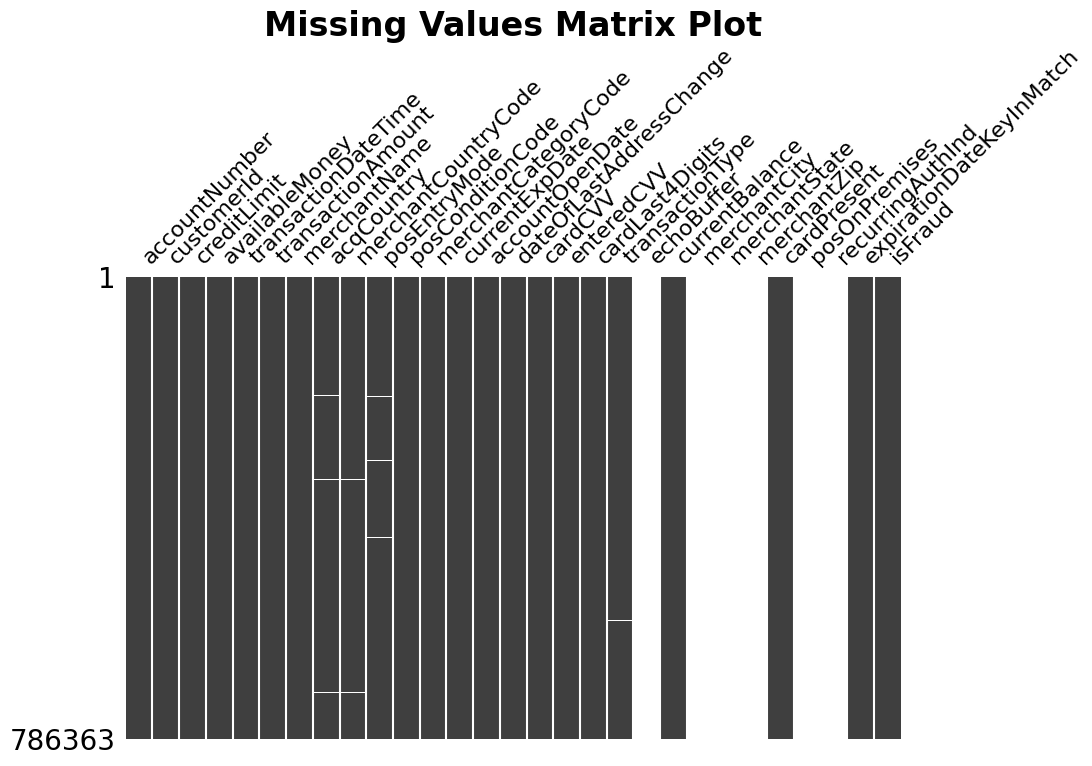

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
msno.matrix(df, ax=ax, sparkline=False)
ax.set_title('Missing Values Matrix Plot', fontsize=24, fontweight='semibold')
plt.show()

In [8]:
# fig.savefig('missing_values.png')

In [10]:
df.isnull().sum().sort_values(ascending=False)

recurringAuthInd            786363
posOnPremises               786363
merchantZip                 786363
merchantState               786363
merchantCity                786363
echoBuffer                  786363
acqCountry                    4562
posEntryMode                  4054
merchantCountryCode            724
transactionType                698
posConditionCode               409
accountNumber                    0
cardLast4Digits                  0
expirationDateKeyInMatch         0
cardPresent                      0
currentBalance                   0
dateOfLastAddressChange          0
enteredCVV                       0
cardCVV                          0
customerId                       0
accountOpenDate                  0
currentExpDate                   0
merchantCategoryCode             0
merchantName                     0
transactionAmount                0
transactionDateTime              0
availableMoney                   0
creditLimit                      0
isFraud             

### Drop features with all missing values

In [14]:
df.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], inplace=True)

In [15]:
df.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)

### Fill missing values for "acqCountry" by grouping with "merchantCountryCode"

In [16]:
len_same = len(df.loc[np.where((df.acqCountry == df.merchantCountryCode))])
len_diff = len(df.loc[np.where((df.acqCountry != df.merchantCountryCode) & ~(df.acqCountry.isna()))])
print(len_same)
print(len_diff)

print(f'{np.round(len_same / (len_same + len_diff)*100, 2)}% of records have the same value for "acqCountry" and "merchantCountryCode"')

781731
70
99.99% of records have the same value for "acqCountry" and "merchantCountryCode"


In [17]:
df.loc[:, 'acqCountry'] = df.groupby('merchantCountryCode')['acqCountry'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.iloc[0])
df.isnull().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                   724
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

### Fill in remaining missing values using SimpleImputer

In [18]:
missing_features = df.columns[df.isna().any()].tolist()
imputer = SimpleImputer(strategy='most_frequent')
df2 = df.copy()
df2.loc[:, missing_features] = pd.DataFrame(imputer.fit_transform(df2[missing_features]), columns=missing_features)

In [19]:
df2.isnull().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

## Feature Extraction

### Converting date columns into datetime format

In [20]:
df2['transactionDateTime'] = pd.to_datetime(df2['transactionDateTime'], errors='coerce')
df2['accountOpenDate'] = pd.to_datetime(df2['accountOpenDate'], errors='coerce')
df2['dateOfLastAddressChange'] = pd.to_datetime(df2['dateOfLastAddressChange'], errors='coerce')
df2['currentExpDate'] = pd.to_datetime(df2.currentExpDate, errors='coerce')

/tmp/ipykernel_23637/1743560075.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['currentExpDate'] = pd.to_datetime(df2.currentExpDate, errors='coerce')


### Getting the day name of transactions

In [21]:
df2['trans_day_name'] = df2.transactionDateTime.apply(lambda x: datetime.strftime(x, '%A'))
df2['trans_day_name'].head()


0    Saturday
1     Tuesday
2     Tuesday
3    Saturday
4    Thursday
Name: trans_day_name, dtype: object

In [23]:
df2['trans_month'] = df2.transactionDateTime.apply(lambda x: int(datetime.strftime(x, '%m')))
df2['trans_month_name'] = df2.transactionDateTime.apply(lambda x: datetime.strftime(x, '%b'))
df2[['trans_month', 'trans_month_name']].head()

,trans_month,trans_month_name
0,8,Aug
1,10,Oct
2,11,Nov
3,12,Dec
4,3,Mar


In [24]:
df2['trans_hour'] = df2.transactionDateTime.apply(lambda x: datetime.strftime(x, '%H'))
df2[['transactionDateTime', 'trans_hour']].head()

,transactionDateTime,trans_hour
0,2016-08-13 14:27:32,14
1,2016-10-11 05:05:54,05
2,2016-11-08 09:18:39,09
3,2016-12-10 02:14:50,02
4,2016-03-24 21:04:46,21


In [26]:
print(df2[['transactionDateTime', 'trans_month', 'trans_day_name', 'trans_hour']].head().to_latex())

\begin{tabular}{llrll}
\toprule
 & transactionDateTime & trans_month & trans_day_name & trans_hour \\
\midrule
0 & 2016-08-13 14:27:32 & 8 & Saturday & 14 \\
1 & 2016-10-11 05:05:54 & 10 & Tuesday & 05 \\
2 & 2016-11-08 09:18:39 & 11 & Tuesday & 09 \\
3 & 2016-12-10 02:14:50 & 12 & Saturday & 02 \\
4 & 2016-03-24 21:04:46 & 3 & Thursday & 21 \\
\bottomrule
\end{tabular}



In [27]:
df2['trans_day_addr_change_diff'] = (df2.transactionDateTime - df2.dateOfLastAddressChange).dt.days
df2['trans_day_addr_change_diff']

0          518
1          577
2          605
3          637
4          231
          ... 
786358    1582
786359    1585
786360    1587
786361    1589
786362    1590
Name: trans_day_addr_change_diff, Length: 786363, dtype: int64

In [32]:
df2['trans_day_open_date_diff'] = (df2.transactionDateTime - df2.accountOpenDate).dt.days
df2['trans_day_open_date_diff']

0          518
1          577
2          605
3          637
4          231
          ... 
786358    1582
786359    1585
786360    1587
786361    1589
786362    1590
Name: trans_day_open_date_diff, Length: 786363, dtype: int64

In [29]:
df2['exp_trans_day_diff'] = (df2.currentExpDate - df2.transactionDateTime).dt.days
df2['exp_trans_day_diff'].head()

0    2482
1    2668
2    3187
3    3155
4    4938
Name: exp_trans_day_diff, dtype: int64

In [34]:
df2[['transactionDateTime', 'dateOfLastAddressChange', 'accountOpenDate', 'trans_day_addr_change_diff', 'trans_day_open_date_diff', 'exp_trans_day_diff']].head()

,transactionDateTime,dateOfLastAddressChange,accountOpenDate,trans_day_addr_change_diff,trans_day_open_date_diff,exp_trans_day_diff
0,2016-08-13 14:27:32,2015-03-14,2015-03-14,518,518,2482
1,2016-10-11 05:05:54,2015-03-14,2015-03-14,577,577,2668
2,2016-11-08 09:18:39,2015-03-14,2015-03-14,605,605,3187
3,2016-12-10 02:14:50,2015-03-14,2015-03-14,637,637,3155
4,2016-03-24 21:04:46,2015-08-06,2015-08-06,231,231,4938


In [35]:
print(df2[['transactionDateTime', 'dateOfLastAddressChange', 'accountOpenDate', 'trans_day_addr_change_diff', 'trans_day_open_date_diff', 'exp_trans_day_diff']].head().to_latex())

\begin{tabular}{llllrrr}
\toprule
 & transactionDateTime & dateOfLastAddressChange & accountOpenDate & trans_day_addr_change_diff & trans_day_open_date_diff & exp_trans_day_diff \\
\midrule
0 & 2016-08-13 14:27:32 & 2015-03-14 00:00:00 & 2015-03-14 00:00:00 & 518 & 518 & 2482 \\
1 & 2016-10-11 05:05:54 & 2015-03-14 00:00:00 & 2015-03-14 00:00:00 & 577 & 577 & 2668 \\
2 & 2016-11-08 09:18:39 & 2015-03-14 00:00:00 & 2015-03-14 00:00:00 & 605 & 605 & 3187 \\
3 & 2016-12-10 02:14:50 & 2015-03-14 00:00:00 & 2015-03-14 00:00:00 & 637 & 637 & 3155 \\
4 & 2016-03-24 21:04:46 & 2015-08-06 00:00:00 & 2015-08-06 00:00:00 & 231 & 231 & 4938 \\
\bottomrule
\end{tabular}



In [40]:
df2.currentExpDate.apply(lambda x:int(datetime.strftime(x, '%m')))

0          6
1          2
2          8
3          8
4         10
          ..
786358    12
786359     8
786360     8
786361     7
786362     5
Name: currentExpDate, Length: 786363, dtype: int64

In [42]:
df2.currentExpDate[:10].apply(lambda x:int(datetime.strftime(x, '%Y')))

0    2023
1    2024
2    2025
3    2025
4    2029
5    2020
6    2020
7    2021
8    2032
9    2020
Name: currentExpDate, dtype: int64

In [43]:
df2['exp_month'] = df2.currentExpDate.apply(lambda x:int(datetime.strftime(x, '%m')))
df2['exp_year'] = df2.currentExpDate.apply(lambda x:int(datetime.strftime(x, '%Y')))
df2[['currentExpDate', 'exp_month', 'exp_year']].head()

,currentExpDate,exp_month,exp_year
0,2023-06-01,6,2023
1,2024-02-01,2,2024
2,2025-08-01,8,2025
3,2025-08-01,8,2025
4,2029-10-01,10,2029


In [45]:
df2['matchingCVV'] = df2.cardCVV == df2.enteredCVV
df2.matchingCVV.value_counts()

matchingCVV
True     779348
False      7015
Name: count, dtype: int64

In [46]:
df2[['cardCVV', 'enteredCVV', 'matchingCVV']].head()

,cardCVV,enteredCVV,matchingCVV
0,414,414,True
1,486,486,True
2,486,486,True
3,486,486,True
4,885,885,True


In [47]:
print(df2[['cardCVV', 'enteredCVV', 'matchingCVV']].head().to_latex())

\begin{tabular}{lrrr}
\toprule
 & cardCVV & enteredCVV & matchingCVV \\
\midrule
0 & 414 & 414 & True \\
1 & 486 & 486 & True \\
2 & 486 & 486 & True \\
3 & 486 & 486 & True \\
4 & 885 & 885 & True \\
\bottomrule
\end{tabular}



In [48]:
df2['brandName'] = df2['merchantName'].apply(lambda x: x.split('#')[0].strip())
df2[['merchantName', 'brandName']].head(10)

,merchantName,brandName
0,Uber,Uber
1,AMC #191138,AMC
2,Play Store,Play Store
3,Play Store,Play Store
4,Tim Hortons #947751,Tim Hortons
5,In-N-Out #422833,In-N-Out
6,Krispy Kreme #685312,Krispy Kreme
7,Shake Shack #968081,Shake Shack
8,Burger King #486122,Burger King
9,Five Guys #510989,Five Guys


In [51]:
df2.brandName.nunique()

205

In [22]:
df2.to_csv('transactions_clean.csv', index=False)